# Blind injection study 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# read data
data = pd.read_csv("data.txt", sep = ",")

In [3]:
data.head()

,x,y1,y2,y3
0,-10.00000,-27.835948,-1.204022,32.752084
1,-9.97998,-29.139783,-2.574528,31.335606
2,-9.95996,-28.501142,-2.001794,31.858014
3,-9.93994,-27.178927,-0.744721,33.060393
4,-9.91992,-27.492202,-1.122373,32.623676


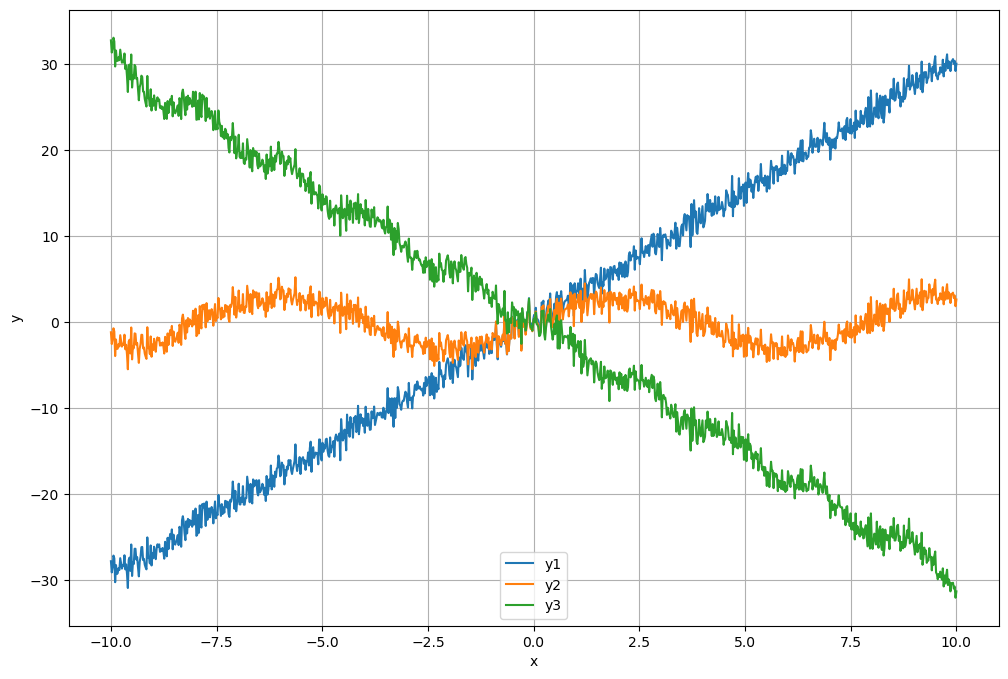

In [4]:
# plot data
plt.figure(figsize=(12, 8))
plt.plot(data['x'], data['y1'], label='y1')
plt.plot(data['x'], data['y2'], label='y2')
plt.plot(data['x'], data['y3'], label='y3')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

The statistical model is y ~ $N(f(x,\beta ),1)$ that each y is normally distributed with the mean of $f(x,\beta )$ and variance of 1. i.e., For i=,...,n,  $y_i  =f(x_i,\beta ) + e_i , e_i$ ~ N(0,1) 


## y1

It can be seen from the image of y1 that y1 has both a linear growth trend and an oscillation trend.
So we can first assume that the model of y1 is $y_1 = \beta_0 + \beta_1 + \beta_2 sin(f *x) + e$

$\beta_0$ - intercept

$\beta_1$ - slope

$\beta_2$ - amplitude

$f$ - Oscillation frequency

In [26]:
def log_likelihood_y1(params,x,y): 
    '''The reason for using log here is mainly to prevent numerical overflow.'''
    beta_0,beta_1,beta_2,f = params
    y_pred = beta_0 + beta_1 * x + beta_2 * np.sin(f * x)
    log_prob = norm.logpdf(y - y_pred, 0, 1)
    log_likelihood = np.sum(log_prob)
    return log_likelihood

In [83]:
def metropolis_hastings(initial_state, iteration,x,y1):
    params_current = np.array(initial_state)
    samples = np.zeros((iteration, len(initial_state)))
    
    for i in range(iteration):
        beta_0_proposal = np.random.normal(params_current[0], 0.5)
        beta_1_proposal = np.random.normal(params_current[1], 0.5)
        beta_2_proposal = np.random.normal(params_current[2], 0.05)
        f_proposal = np.random.normal(params_current[3], 5)
        
        param_proposal = np.array([beta_0_proposal,beta_1_proposal,beta_2_proposal,f_proposal])
        
        log_likelihood_current = log_likelihood_y1(params_current, x, y1)
        log_likelihood_proposal = log_likelihood_y1(param_proposal, x, y1)
        
        accept_ratio = np.exp(log_likelihood_proposal - log_likelihood_current) 
        
        if np.random.uniform(0, 1) <  accept_ratio:
            params_current = param_proposal
            
        samples[i, :] = params_current
    
    return samples

Since the distribution of parameters is not known, it is assumed to be uniform distribution. The prior of uniform distribution is a constant and does not affect the ratio, so it is omitted.

In [84]:
# beta_0,beta_1,beta_2,f
initial_state_y1 = [0,3,5,200]
iteration = 5000

osc_samples = metropolis_hastings(initial_state_y1,iteration,data['x'],data['y1'])

In [85]:
osc_samples

array([[  0.        ,   3.        ,   5.        , 200.        ],
       [  0.        ,   3.        ,   5.        , 200.        ],
       [  0.        ,   3.        ,   5.        , 200.        ],
       ...,
       [  0.34841373,   2.9943124 ,   1.77182916, 216.22344182],
       [  0.34841373,   2.9943124 ,   1.77182916, 216.22344182],
       [  0.34841373,   2.9943124 ,   1.77182916, 216.22344182]])

In [63]:
osc_samples[:,1]

array([3.        , 3.        , 3.01317997, ..., 2.97283216, 2.97283216,
       2.97283216])

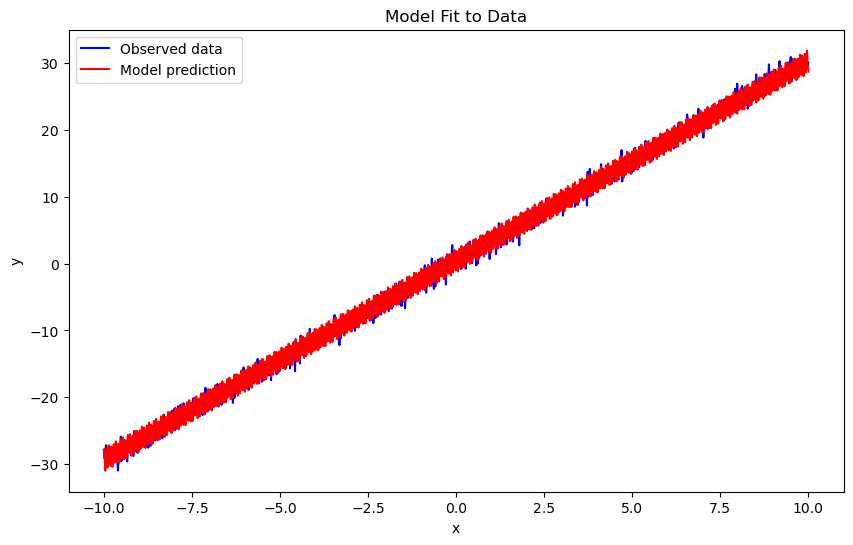

In [90]:
# Given posterior parameter values
params_posterior = np.mean(osc_samples[-100:], axis=0)
beta_0, beta_1, beta_2, f = params_posterior


y_pred = beta_0 + beta_1 * data['x'] + beta_2 * np.sin(f * data['x'])

# Plot the original data and the model predictions
plt.figure(figsize=(10, 6))
plt.plot(data['x'], data['y1'], color='blue', label='Observed data')
plt.plot(data['x'], y_pred, color='red', label='Model prediction')
plt.title('Model Fit to Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In order to eliminate the impact of burn-in on the final, the mean of the last 100 samples is selected as the parameter posterior value selection.